In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['bored_last'] = mood.groupby('user_id')['bored'].shift()
mood.loc[(pd.isnull(mood.bored_last)), 'bored_last'] = mood['bored']
mood_bored = mood.drop(["anxious", "content", "cheerful", "user_id", "response_time"], axis=1)

In [3]:
mood_bored[:5]

,bored,day_time_window,average_TimeUse,bulk,messaging,socialnetworking,otherapp,bored_last
4825,3.0,3.0,0.673000,0,0,0,1,3.0
4826,3.0,4.0,64.314667,0,1,0,2,3.0
245,3.0,1.0,20.590500,0,0,0,2,3.0
4827,3.0,2.0,0.000000,0,0,0,0,3.0
4828,3.0,3.0,53.957200,0,3,0,2,3.0


In [4]:
# Normalize predictors
mood_normz = mood_bored.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [5]:
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]
y = y.astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
X_train[:5]

,day_time_window,average_TimeUse,bulk,messaging,socialnetworking,otherapp,bored_last
10315,1.000000,0.000000,0,0.000000,0.00,0.0,3.0
15108,1.000000,0.024319,0,0.009524,0.02,0.0,0.0
1524,0.000000,0.000000,0,0.000000,0.00,0.0,4.0
5438,0.666667,0.000000,0,0.000000,0.00,0.0,2.0
992,0.000000,0.000000,0,0.000000,0.00,0.0,3.0


In [8]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['bored'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['bored'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 0    5139
1    1927
2    1840
3    1184
4     403
5      83
Name: bored, dtype: int64
After OverSampling, counts of label '0': 5139
After OverSampling, counts of label '1': 5139
After OverSampling, counts of label '2': 5139
After OverSampling, counts of label '3': 5139
After OverSampling, counts of label '4': 5139
After OverSampling, counts of label '5': 5139


In [9]:
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [10]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [11]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [12]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 24667 samples, validate on 6167 samples
Epoch 1/100
24667/24667 [==============================] - 0s 10us/step - loss: 7.5117 - accuracy: 0.1677 - val_loss: 6.2227 - val_accuracy: 0.1704
Epoch 2/100
24667/24667 [==============================] - 0s 5us/step - loss: 4.8557 - accuracy: 0.1672 - val_loss: 3.5812 - val_accuracy: 0.1711
Epoch 3/100
24667/24667 [==============================] - 0s 5us/step - loss: 3.0827 - accuracy: 0.1712 - val_loss: 2.9866 - val_accuracy: 0.1780
Epoch 4/100
24667/24667 [==============================] - 0s 8us/step - loss: 2.8757 - accuracy: 0.1733 - val_loss: 2.9199 - val_accuracy: 0.1756
Epoch 5/100
24667/24667 [==============================] - 0s 7us/step - loss: 2.8346 - accuracy: 0.1721 - val_loss: 2.8925 - val_accuracy: 0.1732
Epoch 6/100
24667/24667 [==============================] - 0s 7us/step - loss: 2.8178 - accuracy: 0.1715 - val_loss: 2.8802 - val_accuracy: 0.1737
Epoch 7/100
24667/24667 [==============================] - 0s 5us/st

24667/24667 [==============================] - 0s 4us/step - loss: 2.7412 - accuracy: 0.1764 - val_loss: 2.7890 - val_accuracy: 0.1840
Epoch 57/100
24667/24667 [==============================] - 0s 4us/step - loss: 2.7406 - accuracy: 0.1761 - val_loss: 2.7908 - val_accuracy: 0.1845
Epoch 58/100
24667/24667 [==============================] - 0s 4us/step - loss: 2.7385 - accuracy: 0.1757 - val_loss: 2.7940 - val_accuracy: 0.1808
Epoch 59/100
24667/24667 [==============================] - 0s 4us/step - loss: 2.7382 - accuracy: 0.1759 - val_loss: 2.7898 - val_accuracy: 0.1831
Epoch 60/100
24667/24667 [==============================] - 0s 4us/step - loss: 2.7380 - accuracy: 0.1757 - val_loss: 2.7876 - val_accuracy: 0.1849
Epoch 61/100
24667/24667 [==============================] - 0s 5us/step - loss: 2.7371 - accuracy: 0.1757 - val_loss: 2.7888 - val_accuracy: 0.1816
Epoch 62/100
24667/24667 [==============================] - 0s 4us/step - loss: 2.7368 - accuracy: 0.1769 - val_loss: 2.7867 

In [14]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 2.7223
Test accuracy: 17.97 %


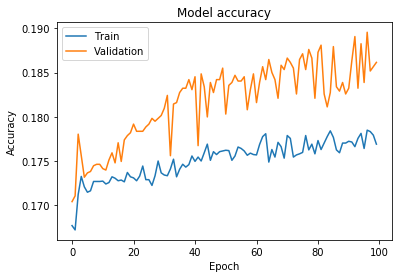

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

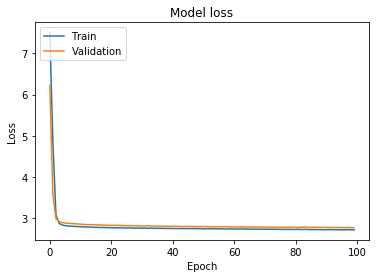

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(X_test_nomood)

In [28]:
pred = []
for a in y_pred:
    for b in a:
        pred.append(round(b))

test = []
for c in y_test['bored']:
    test.append(c)

In [29]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 14.291115311909264


In [21]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlylastmood['bored_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 223 127
wrong   1558 737
Table is right!


In [23]:
from collections import Counter
print("Predicted values: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_bored))

Predicted values:  Counter({3: 2514, 0: 121, 4: 10})
True values:  Counter({0: 1264, 1: 491, 2: 455, 3: 301, 4: 119, 5: 15})
Previous mood: Counter({0.0: 1286, 1.0: 494, 2.0: 451, 3.0: 294, 4.0: 106, 5.0: 14})


In [24]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  45
Same Wrong 0 guesses is:  994
Dif Correct 0 guesses is:  17
Dif Wrong 0 guesses is:  208

Same Correct 1 guesses is:  0
Same Wrong 1 guesses is:  272
Dif Correct 1 guesses is:  0
Dif Wrong 1 guesses is:  219

Same Correct 2 guesses is:  0
Same Wrong 2 guesses is:  232
Dif Correct 2 guesses is:  0
Dif Wrong 2 guesses is:  223

Same Correct 3 guesses is:  178
Same Wrong 3 guesses is:  5
Dif Correct 3 guesses is:  109
Dif Wrong 3 guesses is:  9

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  55
Dif Correct 4 guesses is:  1
Dif Wrong 4 guesses is:  63

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  0
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  15


In [25]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [26]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.5197
Macro-averaged F1-score is:  0.0667


/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
